# Lab1

In [1]:
from IPython.core.display import display, HTML
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

## Library Importation

In [21]:
import pandas as pd
from kernel import *
from model import GaussianProcess
from visualization import visualize_ax
from utils import transform_time_hour, transform_time_day
import matplotlib.pyplot as plt
import numpy as np

# Data Loading

In [3]:
data = pd.read_csv('data/sotonmet.txt', sep=",")

In [4]:
data.head()

,Update Date and Time (ISO),Update Duration (ms),Reading Date and Time (ISO),Air pressure (mb),Air temperature (C),Tide height (m),Wind direction (deg),Wind gust speed (kn),Wind speed (kn),True air temperature (C),True tide height (m),Independent tide height prediction (m),Independent tide height deviation (m),Dependent tide height prediction (m),Dependent tide height deviation (m),Independent air temperature prediction (C),Independent air temperature deviation (C),Dependent air temperature prediction (C),Dependent air temperature deviation (C)
0,2007-05-26T12:05:00,0,2007-05-26T12:05:00,NaN,NaN,NaN,NaN,NaN,NaN,16.92,2.30,2.4007,0.039110,2.3715,0.036670,17.2348,0.23222,17.2339,0.23187
1,2007-05-26T12:10:00,0,2007-05-26T12:10:00,1006.0,16.7,2.3,22.0,12.0,12.4,16.42,2.24,2.4016,0.058707,2.3365,0.045564,17.1932,0.29931,17.1848,0.29732
2,2007-05-26T12:15:00,0,2007-05-26T12:15:00,1006.0,16.0,2.2,13.0,18.1,13.2,16.00,2.19,2.2945,0.037006,2.2836,0.029853,16.8005,0.25186,16.8130,0.24920
3,2007-05-26T12:20:00,0,2007-05-26T12:20:00,1006.0,15.9,2.1,16.0,14.2,13.0,15.92,2.14,2.1455,0.021627,2.1553,0.019945,16.0734,0.17207,16.0621,0.17101
4,2007-05-26T12:25:00,0,2007-05-26T12:25:00,1005.0,16.1,2.1,12.0,14.4,12.0,16.08,2.09,2.0900,0.028609,2.1115,0.023468,15.8401,0.21507,15.8126,0.21158


In [32]:
# Get Data
y = data["Tide height (m)"]
y_norm = (y - np.mean(y)).values

# Ground Truth
y_true = data["True tide height (m)"]
y_true_norm = (y_true - np.mean(y_true)).values


# Reading Time
t = transform_time_day(data["Reading Date and Time (ISO)"])

# training / missing data

t_train = t[~data["Tide height (m)"].isnull()]
t_test = np.linspace(-1, 6, 1600)
t_test_true = t[data["Tide height (m)"].isnull()]

y_train = y_norm[~data["Tide height (m)"].isnull()]
y_test_true = y_true_norm[data["Tide height (m)"].isnull()]

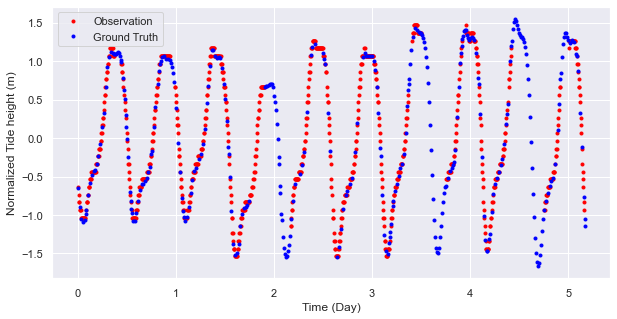

In [37]:
## Plot the data
plt.figure(figsize=(10,5))
plt.plot(t, y_norm, ".", color = "red", label = "Observation")
plt.plot(t_test_true, y_test_true, ".", color = "blue", label = "Ground Truth")
plt.xlabel("Time (Day)")
plt.ylabel("Normalized Tide height (m)")
plt.legend()
plt.savefig("Data.png", dpi = 150)

## Prior Functional Assumption
- Plot Functional Prior for different Kernels

C:\Users\Pierre Osselin\Desktop\Oxford\Course\data_inference\kernel.py:199: RuntimeWarning: invalid value encountered in multiply
  result = part1 * part2 * part3
C:\Users\Pierre Osselin\Desktop\Oxford\Course\data_inference\kernel.py:199: RuntimeWarning: invalid value encountered in multiply
  result = part1 * part2 * part3


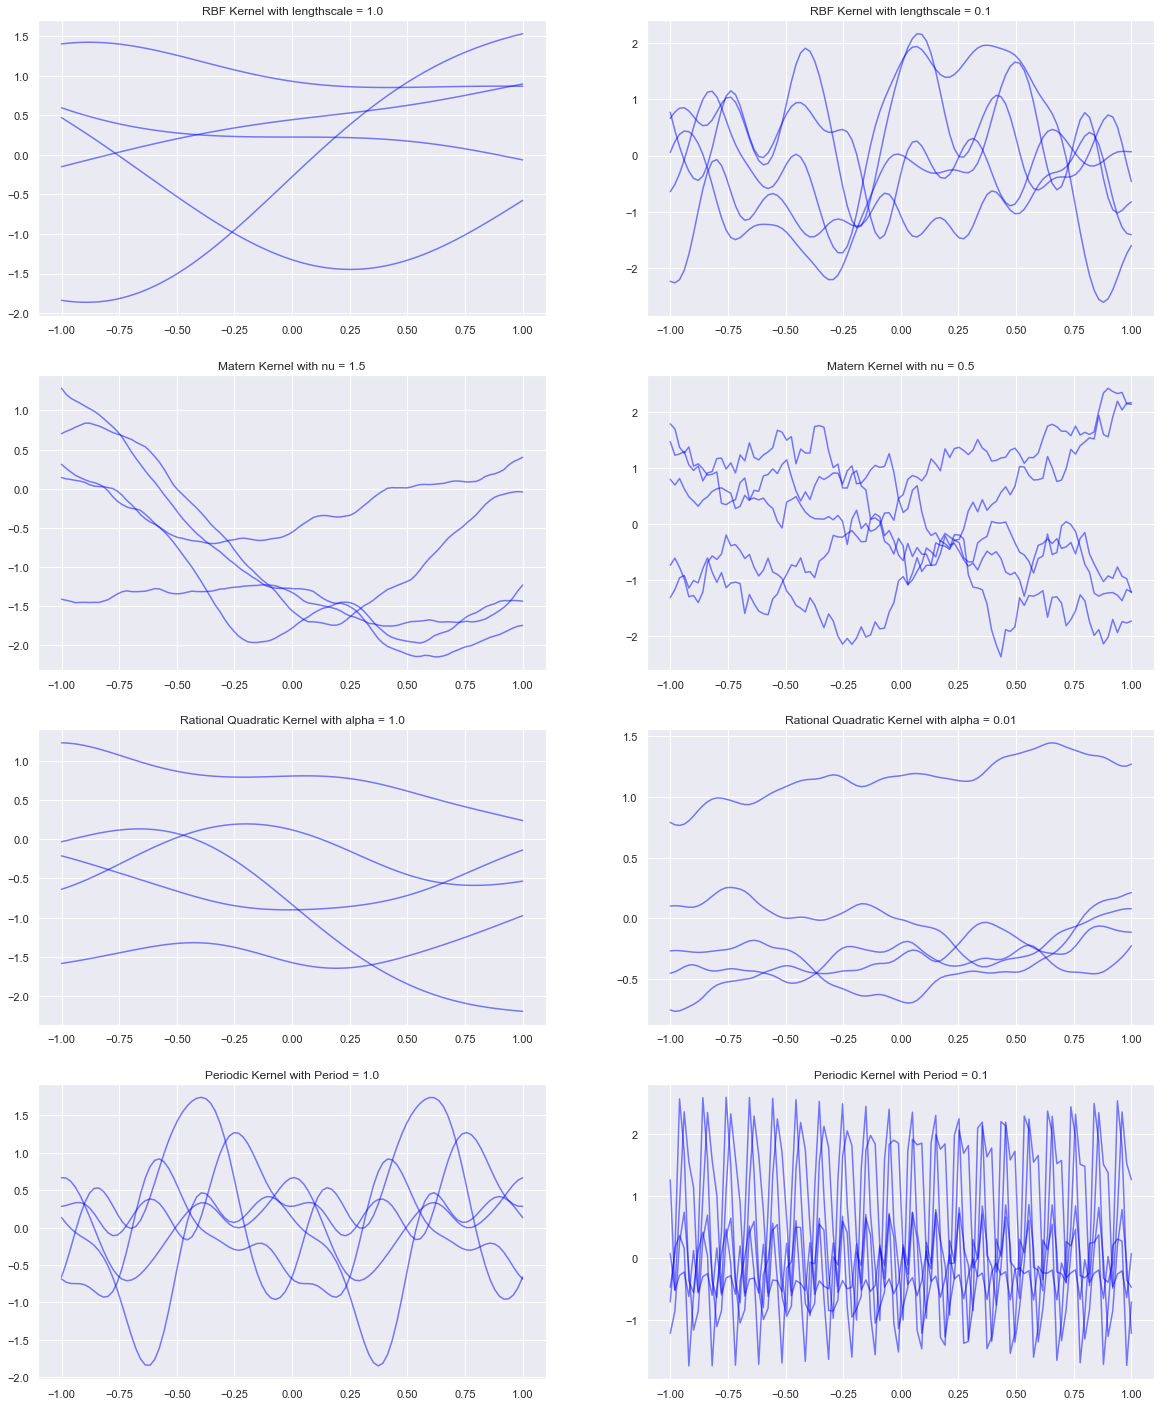

In [7]:
f, axs = plt.subplots(4,2, figsize=(20,25))

x = np.linspace(-1, 1, 100)
list_kernel = [RBF(1.), RBF(0.1), Matern(mu = 3/2), Matern(), RQ(alpha = 1.), RQ(alpha = 0.01), Periodic(p = 1.), Periodic(p = 0.1)]
for i, kernel in enumerate(list_kernel):
    K = kernel.compute_covariance(x.reshape(-1,1))
    samples = np.random.multivariate_normal([0 for i in range(len(x))], K, 5)
    for j in range(5):
        axs[i//2, i%2].plot(x, samples[j], "-", color='blue', alpha=0.5)
        
axs[0,0].set_title("RBF Kernel with lengthscale = {}".format(1.))
axs[0,1].set_title("RBF Kernel with lengthscale = {}".format(0.1))
axs[1,0].set_title("Matern Kernel with nu = {}".format(1.5))
axs[1,1].set_title("Matern Kernel with nu = {}".format(0.5))
axs[2,0].set_title("Rational Quadratic Kernel with alpha = {}".format(1.))
axs[2,1].set_title("Rational Quadratic Kernel with alpha = {}".format(0.01))
axs[3,0].set_title("Periodic Kernel with Period = {}".format(1.))
axs[3,1].set_title("Periodic Kernel with Period = {}".format(0.1))

plt.savefig("PriorSamples.png", dpi = 150)

## Gaussian Process Regression to Predict Missing Data

### Estimate Noise
- With Ground Truth
- With RBF Hyperparameter tuning
- Influence of Noise on Prediction

In [34]:
y_noise = data["Tide height (m)"][~data["Tide height (m)"].isnull()]
y_nnoise = data["True tide height (m)"][~data["Tide height (m)"].isnull()]
noise = np.sqrt(np.mean((y_noise - y_nnoise)**2))
print("Noise estimated : {}".format(noise))

Noise estimated : 0.029336538604165945


-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1574.3687501888342
Value Parameters: [0.06130411 0.80883021 0.02931456]
The noise hyperparameter is 0.02931455630950178


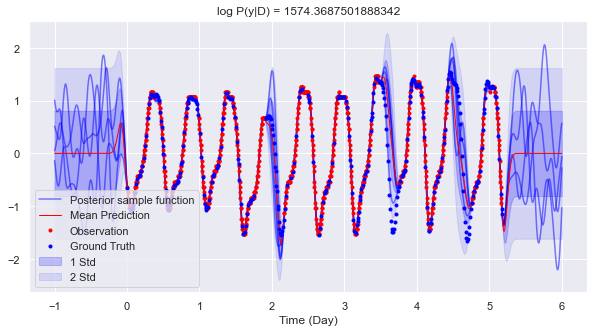

In [36]:
f, ax = plt.subplots(1,1, figsize=(10,5))
kernel = RBF(0.1)
model = GaussianProcess(kernel, noise = 0.5)
model.fit(t_train, y_train)
parameters, score = model.optimize(optimize_noise = True, verbose = 1)
result = model.predict(t_test)
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)
ax.set_title("log P(y|D) = {}".format(score))
print("The noise hyperparameter is {}".format(parameters[-1]))
plt.show()

In [ ]:
## Try noise levels : [0.01, 0.03, 0.1, 0.5] ~ 3 minutes
noise_list = [0.01, 0.03, 0.1, 0.5]
f, axs = plt.subplots(2,2, figsize=(30,15))
kernel = RBF(0.1)

for i, noise in enumerate(noise_list):
    print("Computing noise:", noise)
    model = GaussianProcess(kernel, noise = noise)
    model.fit(t_train, y_train)
    _, score = model.optimize()
    result = model.predict(t_test)
    axs[i // 2, i % 2] = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title("Prediction for noise = {}, log P(y|D) = {}".format(noise, score))

Computing noise: 0.01
Computing noise: 0.03
Computing noise: 0.1


We can 

### Regression with Classical Kernels
- Gaussian Process Regression with Optimized Kernels

### RBF Kernel

In [112]:
## Optimize over noise
f, ax = plt.subplots(figsize=(20,10))

kernel = RBF(1.)
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize(optimize_noise = True)

result = model.predict(t_test)

visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

Text(0.5, 1.0, '$log p(\\boldsymbol{y} | \\boldsymbol{x})$ lol')

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1440x720 with 1 Axes>

### Periodic Kernel

In [78]:
## Apply Gaussian Process Prediction

kernel = Periodic(1., 25.)
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 367.6835006575884
Value Parameters: [ 0.45149179 24.70099541  0.85386977  0.15262756]


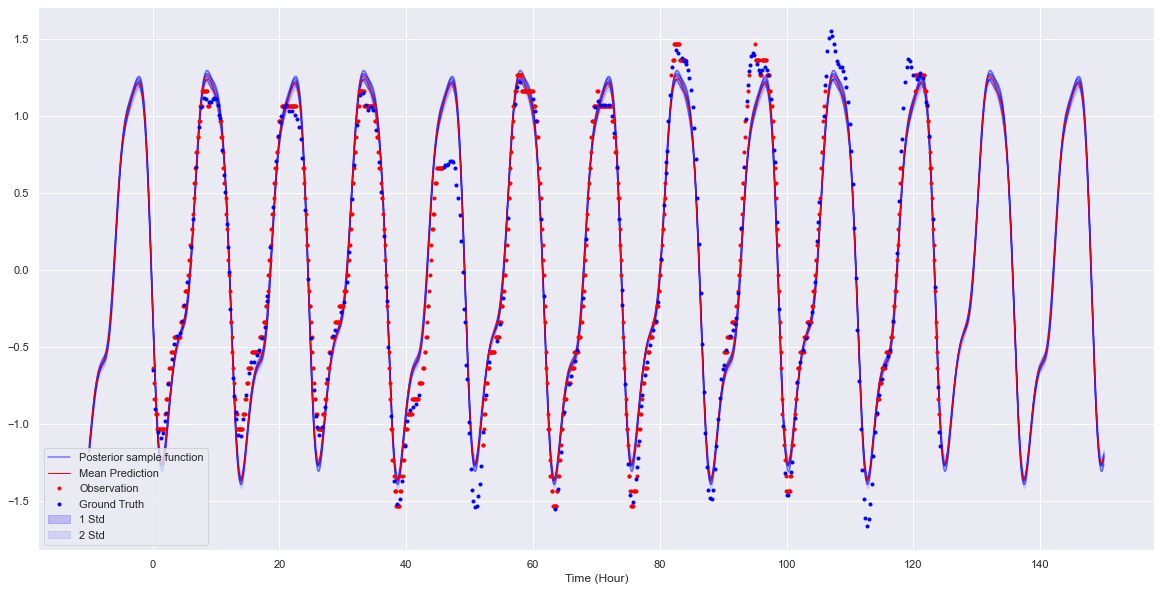

In [82]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic + RBF Kernel

In [83]:
## Apply Gaussian Process Prediction

kernel = Add_Kernel(RBF(), Periodic(1., 25.))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1653.6863883760784
Value Parameters: [ 1.19820514  0.17624702  0.3521879  24.70655223  0.71706403  0.02885915]


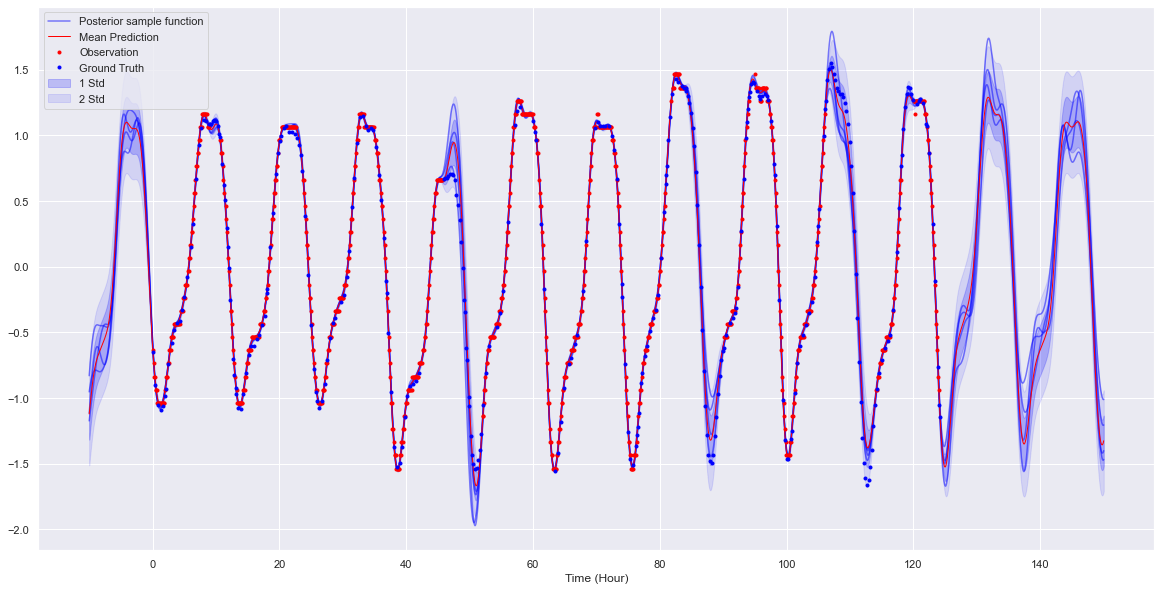

In [84]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic x RBF Kernel

In [85]:
## Apply Gaussian Process Prediction

kernel = Multiply_Kernel(RBF(), Periodic(1., 25.))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize_log()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1588.2314182132452
Value Parameters: [3.39552616 1.08623538 4.4979785  5.29741697 1.08510521 0.02901552]


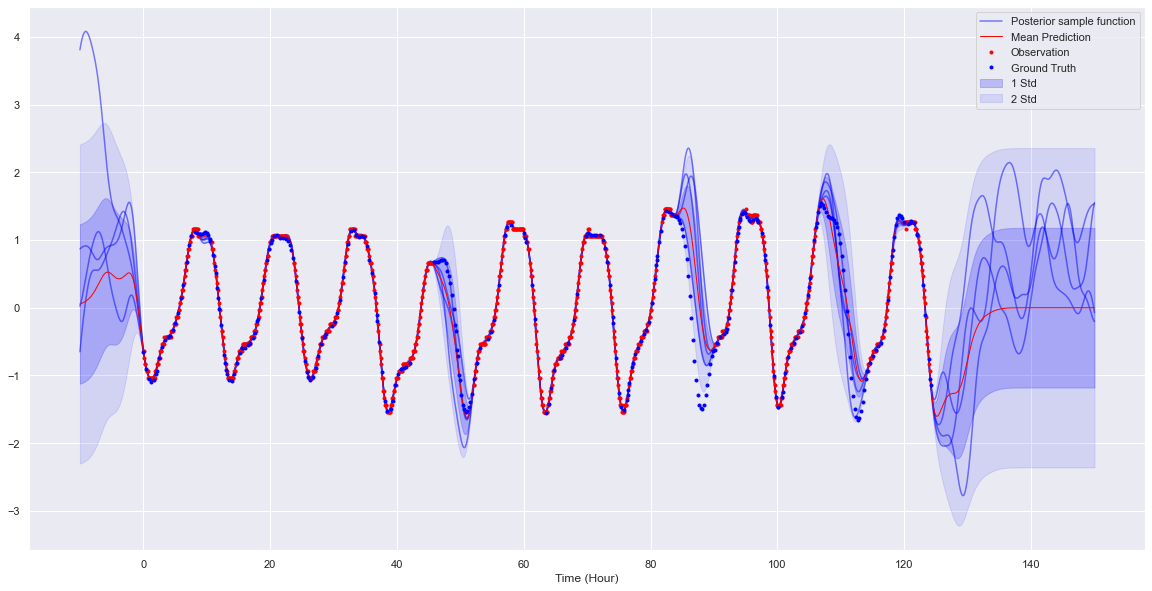

In [86]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Periodic x RBF + Periodic + RBF Kernel

In [43]:
## Apply Gaussian Process Prediction

kernel = Add_Kernel(Multiply_Kernel(RBF(), Periodic(1., 25.)), Add_Kernel(RBF(), Periodic(1., 25.)))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize()

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1662.6682922508803
Value Parameters: [ 0.95104525  0.30665269  0.82180129 19.43150799  0.30664359  3.50413349
  0.18872891  0.43585825 24.74632846  0.85460921  0.02860065]


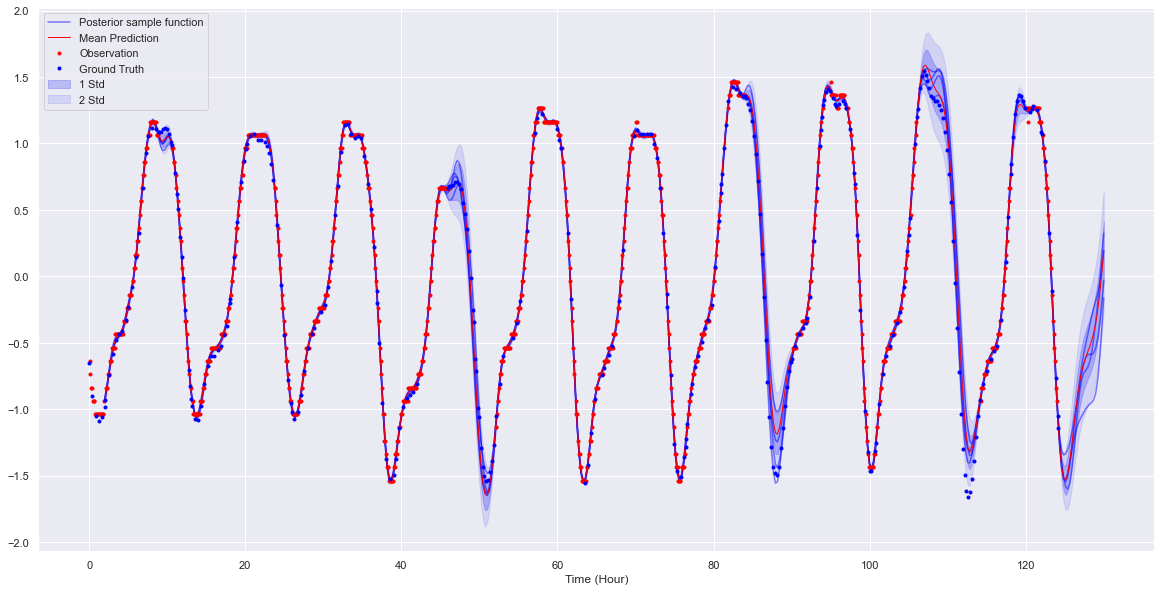

In [44]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Sequential

In [28]:
kernel = Add_Kernel(Multiply_Kernel(RBF(), Periodic(1., 25.)), Add_Kernel(RBF(), Periodic(1., 25.)))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)


lookahead = 1.
t_test = np.linspace(0.,130., 500)
mean_prediction_sequential, var_prediction_sequential = model.sequential_prediction(t_test, split = 10., optimization = True, verbose = 1)

 11%|█████████▎                                                                          | 1/9 [00:00<00:06,  1.31it/s]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 174.28439508680776
Value Parameters: [1.84660404e+00 6.50317940e-01 1.18258451e+00 4.55644128e+01
 6.53765730e-01 6.43196088e-01 5.42496029e-02 5.37434746e-02
 2.11360365e+02 6.87739980e-01]


 22%|██████████████████▋                                                                 | 2/9 [00:03<00:10,  1.49s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 386.04437004060827
Value Parameters: [1.29870565e+01 2.11911693e-02 9.94456297e-01 2.21343960e+01
 2.12497233e-02 4.74943060e-01 1.83075205e-02 4.57737605e-01
 2.52615180e+01 7.62627038e-01]


 33%|████████████████████████████                                                        | 3/9 [00:13<00:23,  3.95s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 616.4611459413582
Value Parameters: [ 5.87291907  0.4435317   1.28850154 33.03451614  0.44299305  0.64790447
  0.04336986  0.48740961 25.06474282  0.83485588]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:34<00:45,  9.14s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 740.3066108057714
Value Parameters: [ 0.82270021  0.25656611  1.03769503 25.45598667  0.25654247 14.6708296
  0.18036141  0.46212918 24.96530296  0.79085806]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:28<01:29, 22.47s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 972.5031135532892
Value Parameters: [ 0.96066062  0.29831892  1.02637154 25.0985794   0.29850072  7.06824702
  0.14459955  0.40974621 24.86295632  0.74132737]


 67%|████████████████████████████████████████████████████████                            | 6/9 [02:31<01:44, 34.76s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1200.1248172049836
Value Parameters: [ 1.15885141  0.3403789   0.98980279 23.78964929  0.33992784  9.81973564
  0.13594077  0.39242435 24.81281891  0.73900767]


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:16<01:51, 55.59s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1312.2044129790806
Value Parameters: [ 1.04398483  0.33161364  1.02817275 24.98714083  0.33172354  9.1003455
  0.14254614  0.41707703 24.81251538  0.78197358]
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1492.2519234054735
Value Parameters: [ 1.02844777  0.34858334  0.94853632 22.25704722  0.34852371  9.41231476
  0.15449091  0.43647604 24.76819679  0.8362517 ]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [05:39<01:04, 64.03s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1579.9267089339914
Value Parameters: [ 0.93345011  0.3044346   0.88956399 21.03769491  0.3046335   3.58154457
  0.18561768  0.44788812 24.76147377  0.87010502]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:19<00:00, 48.88s/it]


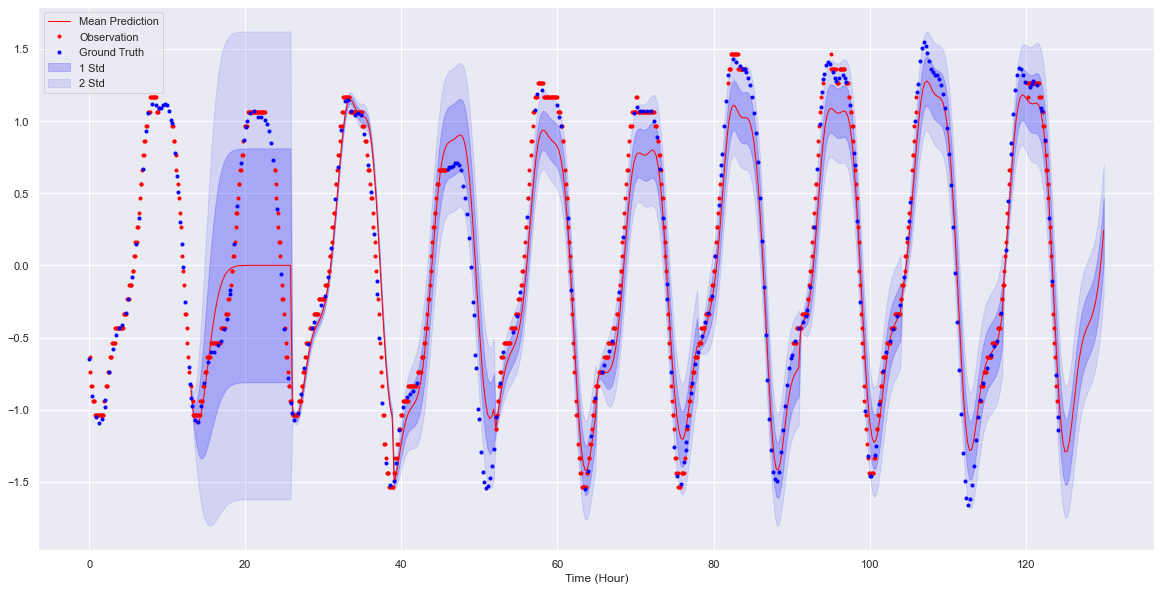

In [29]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  (np.array(np.split(t_test, 10)[1:])).flatten(), [mean_prediction_sequential, var_prediction_sequential], ax, size = 0)

In [39]:
np.array(np.split(t_test, 10)[1])

t_test_debug = np.split(t_test, 5)[1]
t_train_debug = t_train[t_train <= t_test_debug[0]]
y_train_debug = y_train[t_train <= t_test_debug[0]]

In [40]:
len(t_test)

500

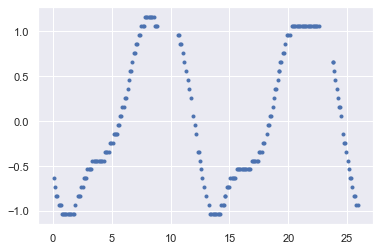

In [41]:
plt.plot(t_train_debug,y_train_debug, '.' )

In [42]:
kernel = Add_Kernel(Multiply_Kernel(RBF(), Periodic(1., 25.)), Add_Kernel(RBF(), Periodic(1., 25.)))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train_debug, y_train_debug)
model.optimize()

array([1.29870565e+01, 2.11911693e-02, 9.94456297e-01, 2.21343960e+01,
       2.12497233e-02, 4.74943060e-01, 1.83075205e-02, 4.57737605e-01,
       2.52615180e+01, 7.62627038e-01])

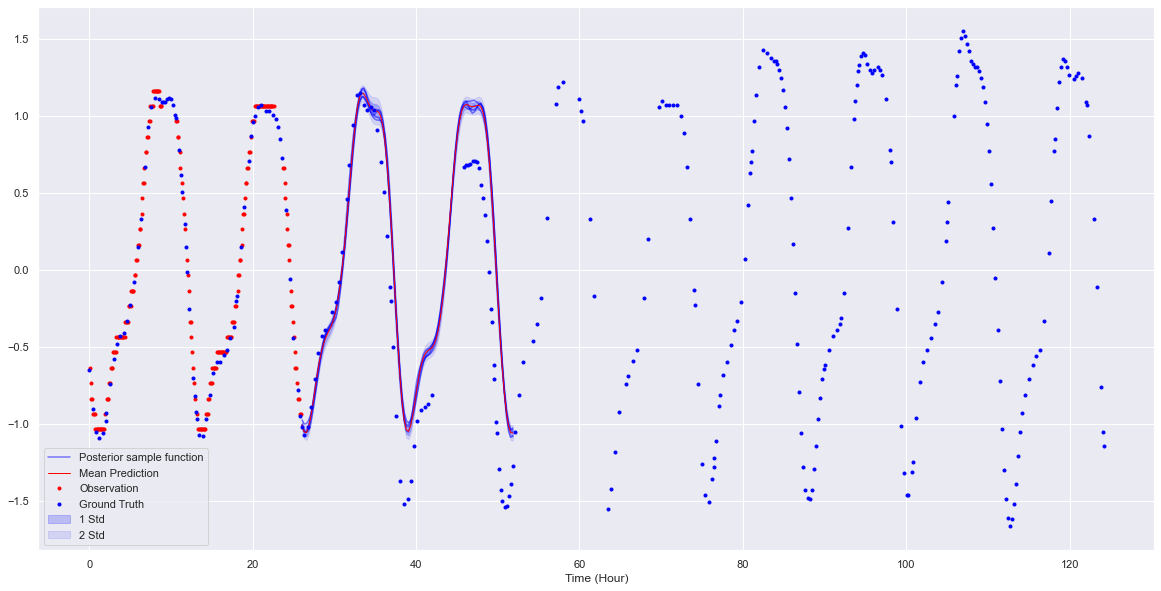

In [43]:
result = model.predict(t_test_debug)

f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train_debug, y_train_debug, t_test_true, y_test_true,  t_test_debug, result, ax)

ValueError: x and y must have same first dimension, but have shapes (50,) and (500,)

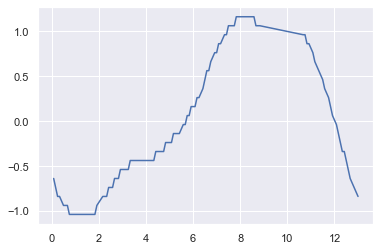

In [22]:
plt.plot(t_train_debug, y_train_debug)
plt.plot(t_test_debug, result[0])

In [23]:
t_test_debug

array([13.0260521 , 13.28657315, 13.54709419, 13.80761523, 14.06813627,
       14.32865731, 14.58917836, 14.8496994 , 15.11022044, 15.37074148,
       15.63126253, 15.89178357, 16.15230461, 16.41282565, 16.67334669,
       16.93386774, 17.19438878, 17.45490982, 17.71543086, 17.9759519 ,
       18.23647295, 18.49699399, 18.75751503, 19.01803607, 19.27855711,
       19.53907816, 19.7995992 , 20.06012024, 20.32064128, 20.58116232,
       20.84168337, 21.10220441, 21.36272545, 21.62324649, 21.88376754,
       22.14428858, 22.40480962, 22.66533066, 22.9258517 , 23.18637275,
       23.44689379, 23.70741483, 23.96793587, 24.22845691, 24.48897796,
       24.749499  , 25.01002004, 25.27054108, 25.53106212, 25.79158317])

In [24]:
result[0]

array([-6.23096944e-001, -7.94307047e-001, -9.23099078e-001,
       -1.00391741e+000, -1.04407614e+000, -1.05378543e+000,
       -1.03564431e+000, -9.85596061e-001, -9.03527487e-001,
       -8.00056017e-001, -6.92260276e-001, -5.95412840e-001,
       -5.19740131e-001, -4.70622365e-001, -4.45990403e-001,
       -4.33104449e-001, -4.13080651e-001, -3.72891899e-001,
       -3.12905030e-001, -2.41776281e-001, -1.65236205e-001,
       -8.05106253e-002,  2.09125668e-002,  1.47341232e-001,
        3.01140648e-001,  4.74368564e-001,  6.49769882e-001,
        8.09385615e-001,  9.43503506e-001,  1.04991208e+000,
        1.12535759e+000,  1.16210547e+000,  1.15607388e+000,
        1.11719204e+000,  1.06857584e+000,  1.03374943e+000,
        1.02383478e+000,  1.03453017e+000,  1.05121650e+000,
        1.05506319e+000,  1.02749183e+000,  9.55006229e-001,
        8.34055649e-001,  6.71454019e-001,  4.78331639e-001,
        2.62893217e-001,  2.94180768e-002, -2.15878579e-001,
       -4.59289832e-001,

In [ ]:
### Multioutput GP

## To Do :
- Debug Sequential Prediction
- Test Other Kernel implemented (Matern, Rational Quadratic)
- Explain why optimization not good when random initialiation : Try optimizer + Marginal Likelihood
- Implement Multioutput Gaussian

In [55]:
## Apply Gaussian Process Prediction

kernel = Add_Kernel(RBF(), Periodic(1., 40.))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize(verbose = 1.)

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1633.5616101421824
Value Parameters: [ 1.10010854  0.18507542  0.29932994 37.07068936  0.88396504]


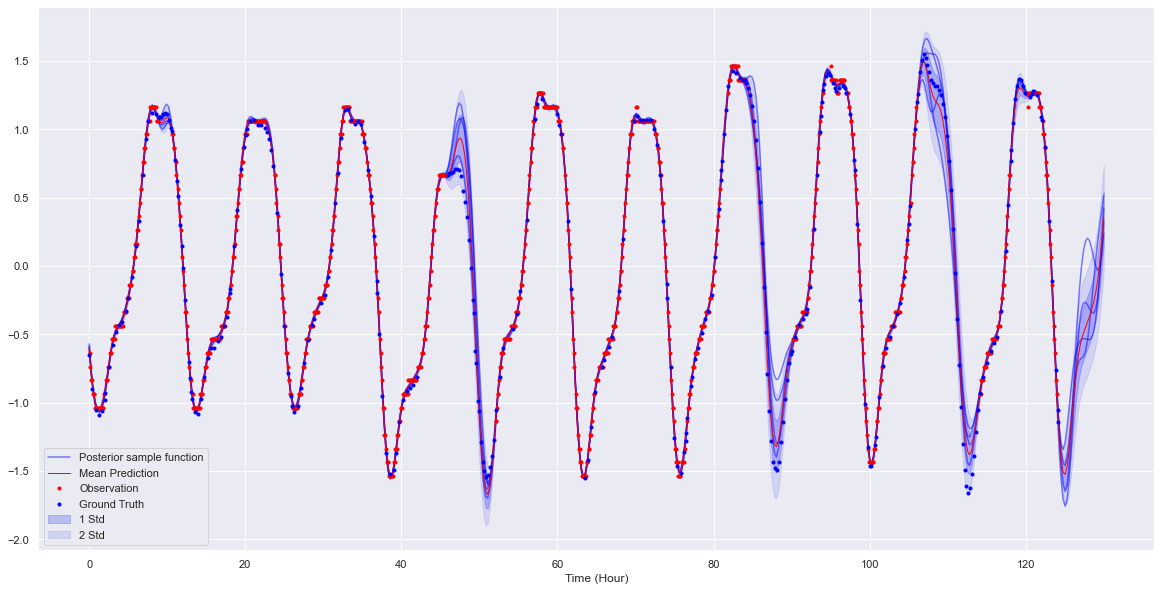

In [54]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)